In [1]:
from photonflux.circuit import PhotonicCircuit
from photonflux.component_models import models_dict
import numpy as np
import networkx as nx
import gdsfactory as gf
import matplotlib.pyplot as plt

2023-02-13 14:37:12.398 | INFO     | gdsfactory.config:<module>:50 - Load '/opt/anaconda3/lib/python3.8/site-packages/gdsfactory' 6.25.0
2023-02-13 14:37:12.802 | INFO     | gdsfactory.technology.layer_views:__init__:779 - Importing LayerViews from KLayout layer properties file: /opt/anaconda3/lib/python3.8/site-packages/gdsfactory/generic_tech/klayout/tech/layers.lyp.


In [2]:
delta_length = 100

mzi_component = gf.components.mzi_phase_shifter_top_heater_metal(
    delta_length=delta_length
)

mzi_netlist_for_test = mzi_component.get_netlist()

In [7]:
print(mzi_netlist_for_test)

{'connections': {'bend_euler_1,o1': 'cp1,o3', 'bend_euler_1,o2': 'syl,o1', 'bend_euler_2,o1': 'syl,o2', 'bend_euler_2,o2': 'sxb,o1', 'bend_euler_3,o1': 'cp1,o2', 'bend_euler_3,o2': 'sytl,o1', 'bend_euler_4,o1': 'sxt,o1', 'bend_euler_4,o2': 'sytl,o2', 'bend_euler_5,o1': 'straight_4,o2', 'bend_euler_5,o2': 'straight_5,o1', 'bend_euler_6,o1': 'straight_5,o2', 'bend_euler_6,o2': 'straight_6,o1', 'bend_euler_7,o1': 'straight_7,o2', 'bend_euler_7,o2': 'straight_8,o1', 'bend_euler_8,o1': 'straight_8,o2', 'bend_euler_8,o2': 'straight_9,o1', 'cp2,o2': 'straight_6,o2', 'cp2,o3': 'straight_9,o2', 'straight_4,o1': 'sxt,o2', 'straight_7,o1': 'sxb,o2'}, 'instances': {'bend_euler_1': {'component': 'bend_euler', 'info': {'length': 16.637, 'dy': 10.0, 'radius_min': 7.061, 'radius': 10.0, 'width': 0.5}, 'settings': {}}, 'bend_euler_2': {'component': 'bend_euler', 'info': {'length': 16.637, 'dy': 10.0, 'radius_min': 7.061, 'radius': 10.0, 'width': 0.5}, 'settings': {}}, 'bend_euler_3': {'component': 'ben

100


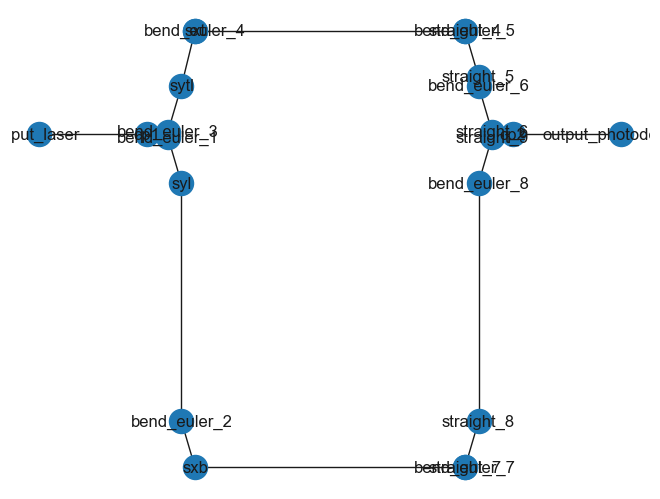

In [3]:
mzi_circuit = PhotonicCircuit(mzi_netlist_for_test, models_dict)

input_port = mzi_circuit.ports[0]
output_port = mzi_circuit.ports[1]

mzi_circuit.add_laser_port(input_port, mzi_circuit.positions)
mzi_circuit.add_photodetector_port(output_port, mzi_circuit.positions)

pos = {k: (v["x"], v["y"]) for k, v in mzi_circuit.positions.items()}

nx.draw(
    mzi_circuit.graph,
    with_labels=True,
    font_weight=8,
    pos=pos,
)

In [4]:
mzi_circuit.update_all_edges()

Text(0, 0.5, 'Power Transmission')

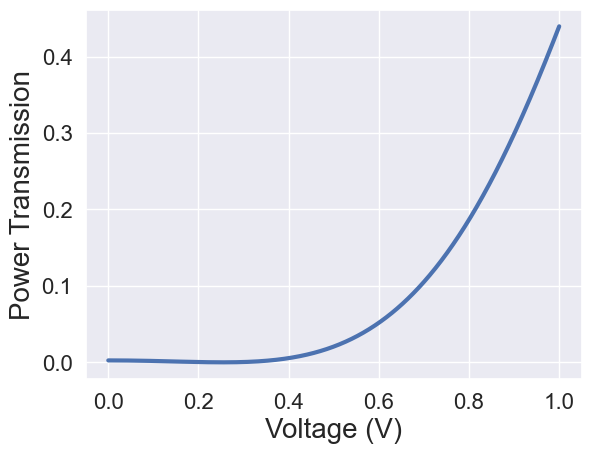

In [5]:
heater_comp_refs = mzi_circuit.return_components_callback(["sxt","sxb"])
heater_ref = heater_comp_refs[0]
voltage_sweep = np.linspace(0,1,num=1000)
storage = []
for v in voltage_sweep:
    heater_ref.update_voltage(v)
    mzi_circuit.update_all_edges()
    detector_value = mzi_circuit.readout_from_photodetectors()
    storage.append(detector_value[0])

heater_ref.update_voltage(0)

plt.figure()
plt.plot(voltage_sweep,storage)
plt.xlabel("Voltage (V)")
plt.ylabel("Power Transmission")

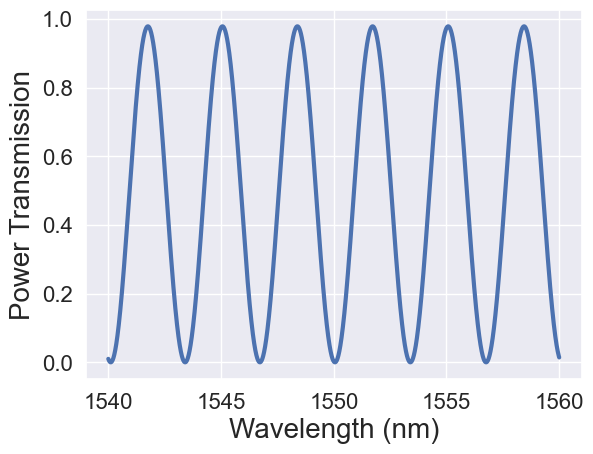

Text(0, 0.5, 'Transmission (dB)')

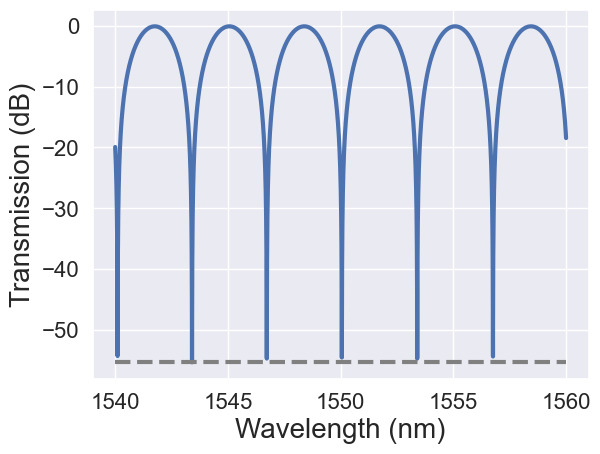

In [6]:
# Wavelength sweep
wavelength_sweep = np.linspace(1.54e-6,1.56e-6,num=10000)
storage = []
for wl in wavelength_sweep:
    mzi_circuit.update_wavelength(wl)
    mzi_circuit.update_all_edges()
    detector_value = mzi_circuit.readout_from_photodetectors()
    storage.append(detector_value[0])

mzi_circuit.update_wavelength(1.55e-6)

plt.figure()
plt.plot(wavelength_sweep*1e9,storage)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Power Transmission")
plt.show()

#What is the extinction ratio of the MZI?
#We are assuming alpha=3dB/cm so calculate that analytically

alpha_m = 300/4.34
delta_length_m = delta_length*1e-6
num = (1 + np.exp(-alpha_m*delta_length_m/2))**2
denom = (1 - np.exp(-alpha_m*delta_length_m/2))**2
ER = num/denom
ER_dB = 10*np.log10(ER)

plt.figure()
plt.plot(wavelength_sweep*1e9,10*np.log10(storage))
plt.hlines(y=-ER_dB,xmin=np.min(wavelength_sweep)*1e9,xmax=np.max(wavelength_sweep)*1e9,color='grey',linestyles='--')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission (dB)")